In [ ]:
# !pip install rasterio

In [ ]:
# !pip install sdd-segmentation
# from sdd_segmentation.sdd import sdd_threshold_selection

In [ ]:
%%shell
wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
conda install -q -y --prefix /usr/local python=3.6 gdal

--2023-03-31 20:29:06--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...

In [ ]:
# !pip install imageio.v3

In [ ]:
# !pip install -U scikit-image

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
# from rasterio.plot import show

In [ ]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst


FILENAME = r"orig_img.tif"

In [ ]:
def show_image(image):
    f = plt.figure(figsize=(5, 5))  
    plt.imshow(image)
    plt.show()  

In [ ]:
def get_image_RGB(filename):
    image = gdal.Open(filename)
    # As, there are 3 bands, we will store in 3 different variables 
    band_1 = image.GetRasterBand(1) # red channel  
    band_2 = image.GetRasterBand(2) # green channel  
    band_3 = image.GetRasterBand(3) # blue channel   
    #band_4 = image.GetRasterBand(4) # alpha channel
    b1 = band_1.ReadAsArray()  
    b2 = band_2.ReadAsArray()  
    b3 = band_3.ReadAsArray()
    # b4 = band_4.ReadAsArray()
    # Normalize input image to range [0, 255]
    normalized_b1 = cv2.normalize(b1, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    normalized_b2 = cv2.normalize(b2, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  
    normalized_b3 = cv2.normalize(b3, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return np.dstack((normalized_b1, normalized_b2, normalized_b3))


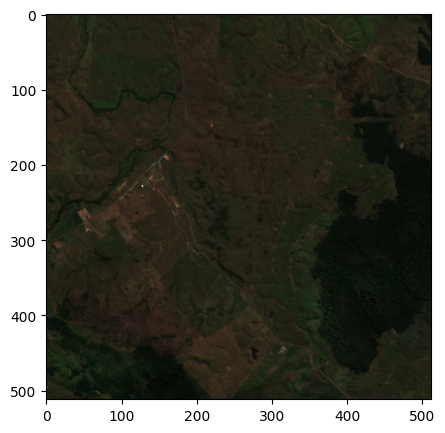

In [ ]:
image_RGB = get_image_RGB(FILENAME)
show_image(image_RGB)

In [ ]:
def print_info_image(filename):
    image = gdal.Open(filename)
    image_arr = image.ReadAsArray()
    print(f'Image as array:', f'dtype: {image_arr.dtype}, shape: {image_arr.shape}, min: {np.min(image_arr)}, max: {np.max(image_arr)}')
    print("Driver: {}/{}".format(image.GetDriver().ShortName,
                                image.GetDriver().LongName))
    print("Size is {} x {} x {}".format(image.RasterXSize,
                                        image.RasterYSize,
                                        image.RasterCount))
    print("Projection is {}".format(image.GetProjection()))
    print("Metadata: {}".format(image.GetMetadata()))
    geotransform = image.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
        

In [ ]:
print_info_image(FILENAME)

Image as array: dtype: uint16, shape: (4, 512, 512), min: 10, max: 6249
Driver: GTiff/GeoTIFF
Size is 512 x 512 x 4
Projection is PROJCS["WGS 84 / UTM zone 24S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-39],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32724"]]
Metadata: {'AREA_OR_POINT': 'Area'}
Origin = (405080.0, 8274420.0)
Pixel Size = (10.0, -10.0)


In [ ]:
def otsu_method(image):
    # For debuging use cv2_imshow
    # Applying Otsu's method setting the flag value into cv.THRESH_OTSU.
    # Use a bimodal image as an input.
    # Optimal threshold value is determined automatically.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # denoise the image with a Gaussian filter
    blurred_image = cv2.GaussianBlur(gray,(5,5),0)

    otsu_threshold, image_result = cv2.threshold(
        blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
    )

    # Remove noise and fill holes in the binary image using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    closed = cv2.morphologyEx(image_result, cv2.MORPH_OPEN, kernel)

    return closed


def draw_contours(thresh, image):
    # Find the contours in the input image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Draw the contours on an image
    contour_img = cv2.drawContours(image, contours, -1, (0, 255, 0), 5)

    return contour_img

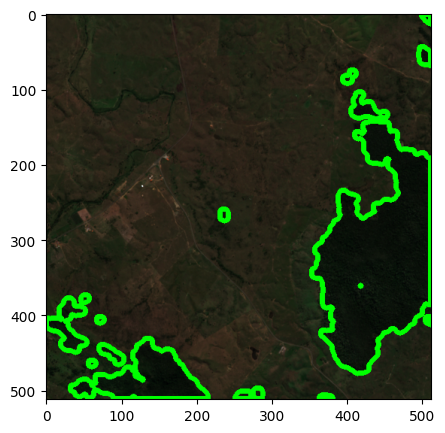

In [ ]:
show_image(draw_contours(otsu_method(get_image_RGB(FILENAME)), get_image_RGB(FILENAME)))

Area: 32438, Width: 159, Height: 337
[INFO] examining component 6/17


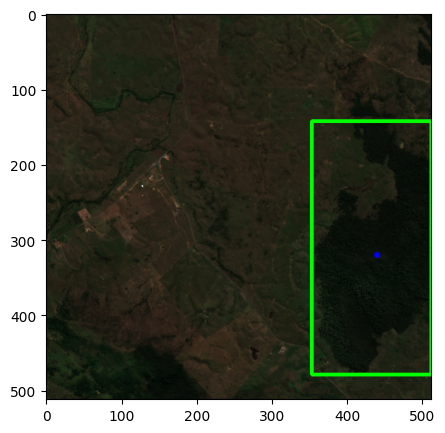

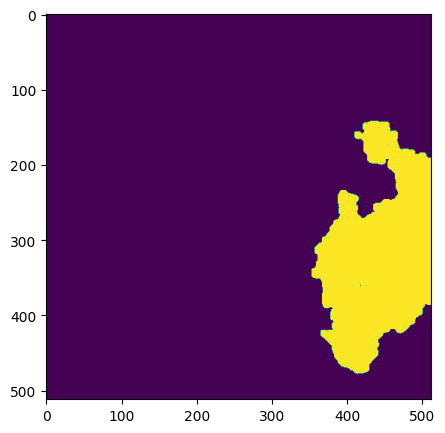

Area: 1890, Width: 55, Height: 74
[INFO] examining component 9/17


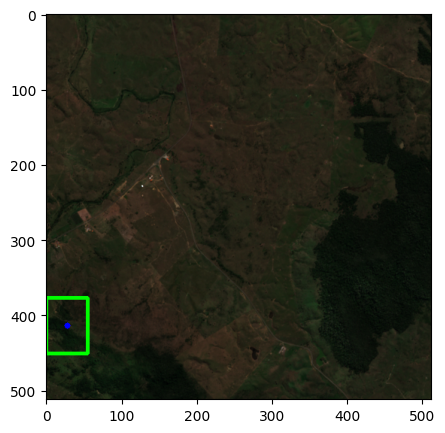

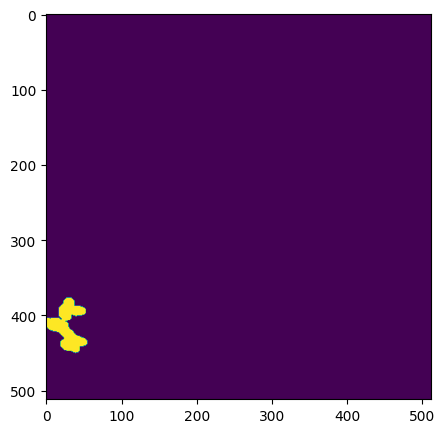

Area: 7426, Width: 184, Height: 81
[INFO] examining component 12/17


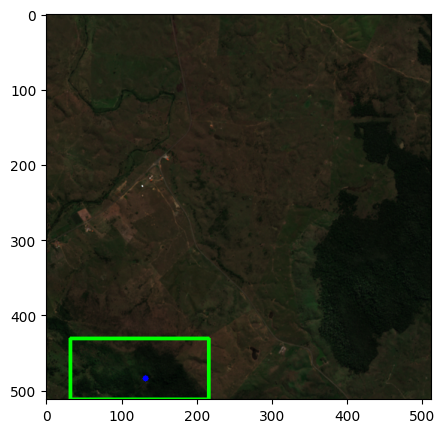

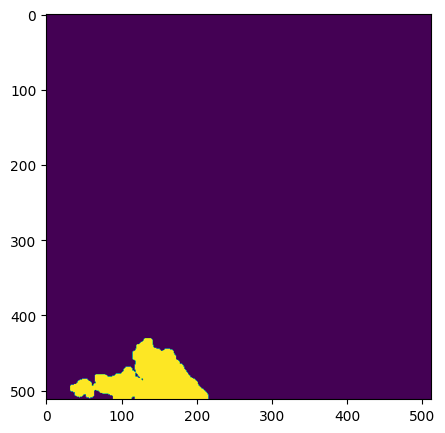

In [ ]:
def connected_components(filename, sigma=1.0, connectivity=2):
    image = get_image_RGB(filename)

    closed = otsu_method(image)

    # perform connected component analysis
    # apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(closed, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    # initialize an output mask to store all forests parsed from
    # the image
    mask = np.zeros(image.shape, dtype="uint8")
    # loop over the number of unique connected component labels
    for i in range(1, numLabels):
      # extract the connected component statistics and centroid for
      # the current label
      x = stats[i, cv2.CC_STAT_LEFT]
      y = stats[i, cv2.CC_STAT_TOP]
      w = stats[i, cv2.CC_STAT_WIDTH]
      h = stats[i, cv2.CC_STAT_HEIGHT]
      area = stats[i, cv2.CC_STAT_AREA]
      # ensure the width, height, and area are all neither too small
      # nor too big
      keepWidth = w > 50
      keepHeight = h > 50
      keepArea = area > 250
      (cX, cY) = centroids[i]
      # ensure the connected component we are examining passes all
      # three tests
      if all((keepWidth, keepHeight, keepArea)):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        print("Area: {}, Width: {}, Height: {}".format(area, w, h))
        if i == 0:
          text = "examining component {}/{} (background)".format(
            i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
          text = "examining component {}/{}".format( i + 1, numLabels)
        # print a status message update for the current connected
        # component
        print("[INFO] {}".format(text))
        # clone our original image (so we can draw on it) and then draw
        # a bounding box surrounding the connected component along with
        # a circle corresponding to the centroid
        output = image.copy()
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
        # construct a mask for the current connected component by
        # finding a pixels in the labels array that have the current
        # connected component ID
        componentMask = (labels == i).astype("uint8") * 255
        # show our output image and connected component mask
        show_image(output)
        show_image(componentMask)

connected_components(FILENAME, sigma=2.0, connectivity=8)

Area: 32438, Width: 159, Height: 337
[INFO] examining component 6/17
Area: 1890, Width: 55, Height: 74
[INFO] examining component 9/17
Area: 7426, Width: 184, Height: 81
[INFO] examining component 12/17


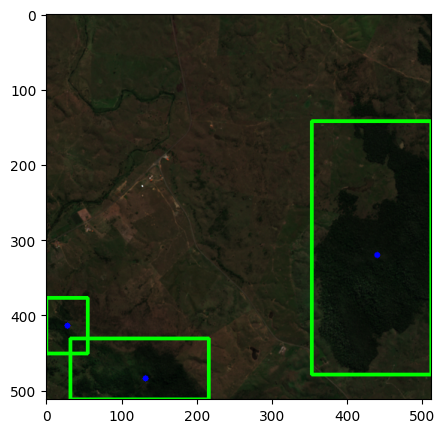

In [ ]:
def connected_components(filename, connectivity=2):
    image = get_image_RGB(filename)
    # clone our original image (so we can draw on it) and then draw
    # a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid
    output_image = image.copy()
    # convert the image to grayscale
    closed = otsu_method(image)

    # perform connected component analysis
    # apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(closed, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    # initialize an output mask to store all forests parsed from
    # the image
    mask = np.zeros(image.shape, dtype="uint8")
    # loop over the number of unique connected component labels
    for i in range(1, numLabels):
      # extract the connected component statistics and centroid for
      # the current label
      x = stats[i, cv2.CC_STAT_LEFT]
      y = stats[i, cv2.CC_STAT_TOP]
      w = stats[i, cv2.CC_STAT_WIDTH]
      h = stats[i, cv2.CC_STAT_HEIGHT]
      area = stats[i, cv2.CC_STAT_AREA]
      # ensure the width, height, and area are all neither too small
      # nor too big
      keepWidth = w > 50
      keepHeight = h > 50
      keepArea = area > 250
      (cX, cY) = centroids[i]
      # ensure the connected component we are examining passes all
      # three tests
      if all((keepWidth, keepHeight, keepArea)):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        print("Area: {}, Width: {}, Height: {}".format(area, w, h))
        if i == 0:
          text = "examining component {}/{} (background)".format(
            i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
          text = "examining component {}/{}".format( i + 1, numLabels)
        # print a status message update for the current connected
        # component
        print("[INFO] {}".format(text))
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.circle(output_image, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    # show our output image and connected component mask
    show_image(output_image)
    plt.imsave(r"CCA.png", output_image)

connected_components(FILENAME, connectivity=8) # sigma=2.0, 

In [ ]:
def NDVI(image_file, t_pixel_forest=0.3, t_is_forest=0.5):
    ds = gdal.Open(image_file)
    red_band = ds.GetRasterBand(1).ReadAsArray().astype(np.float32)
    # If there is NIR_band on the second band we use NIR_band, if not, then we use green
    NIR_band = ds.GetRasterBand(4).ReadAsArray().astype(np.float32) 

    # calculate NDVI
    ndvi = (NIR_band - red_band) / (NIR_band + red_band)

    # classify pixels as forest or non-forest based on a threshold value
    forest_mask = np.where(ndvi >= t_pixel_forest, 1, 0)
    forest_percent = np.average(forest_mask)
    print(forest_percent)
    
    # classify the image based on the percentage of forest cover
    is_forest = True
    if forest_percent >= t_is_forest:
        print('The image contains a forest')
    else:
        is_forest = False
        print('The image does not contain a forest')

    return is_forest

NDVI(r"test.tif")
NDVI(FILENAME)

0.9663200378417969
The image contains a forest
0.9959335327148438
The image contains a forest


True

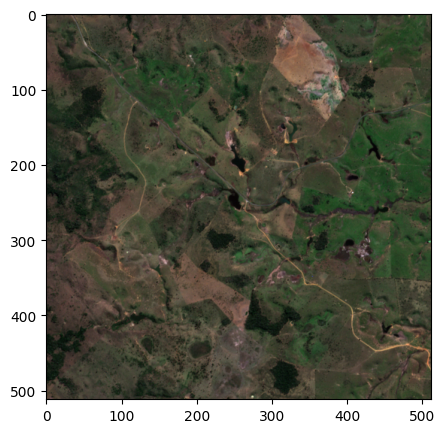

In [ ]:
show_image(get_image_RGB(r"test.tif"))

0.9663200378417969
The image contains a forest
Area: 19717, Width: 126, Height: 305
[INFO] examining component 11/98
Area: 2886, Width: 77, Height: 68
[INFO] examining component 13/98
Area: 7161, Width: 138, Height: 131
[INFO] examining component 15/98
Area: 3130, Width: 75, Height: 113
[INFO] examining component 21/98
Area: 2766, Width: 81, Height: 84
[INFO] examining component 33/98
Area: 8495, Width: 149, Height: 135
[INFO] examining component 42/98
Area: 3623, Width: 95, Height: 72
[INFO] examining component 48/98
Area: 7654, Width: 101, Height: 156
[INFO] examining component 67/98
Area: 7054, Width: 108, Height: 143
[INFO] examining component 69/98
Area: 2806, Width: 79, Height: 64
[INFO] examining component 81/98
Area: 2939, Width: 108, Height: 55
[INFO] examining component 89/98


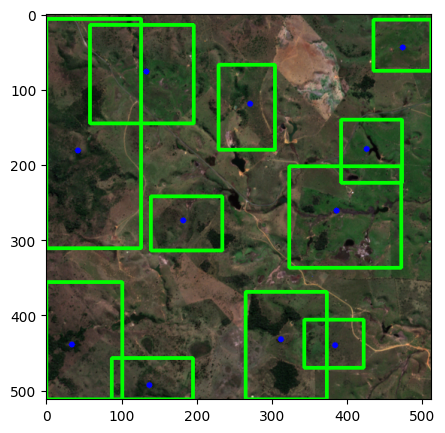

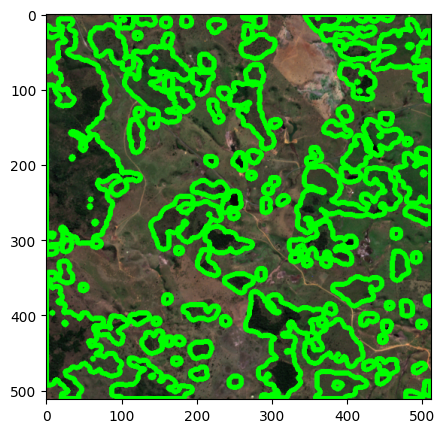

In [ ]:
def main(image_file):
  if NDVI(image_file):
    connected_components(image_file)
    show_image(draw_contours(otsu_method(get_image_RGB(image_file)), get_image_RGB(image_file)))
  else:
    show_image(get_image_RGB(image_file))

main(r"test.tif")

In [ ]:
def spectral_signatures():
  pass

In [ ]:
def get_4_band(image_file):
    ds = gdal.Open(image_file)
    return ds.GetRasterBand(4).ReadAsArray().astype(np.float32)

get_4_band(FILENAME)

array([[2471., 2739., 2822., ..., 3105., 3041., 2873.],
       [2575., 2893., 2832., ..., 2855., 2871., 2578.],
       [2541., 2840., 2735., ..., 2300., 2280., 2496.],
       ...,
       [3186., 3206., 3086., ..., 3255., 3251., 3183.],
       [3212., 3073., 3042., ..., 3387., 3311., 3225.],
       [3178., 3004., 2996., ..., 3376., 3291., 3238.]], dtype=float32)

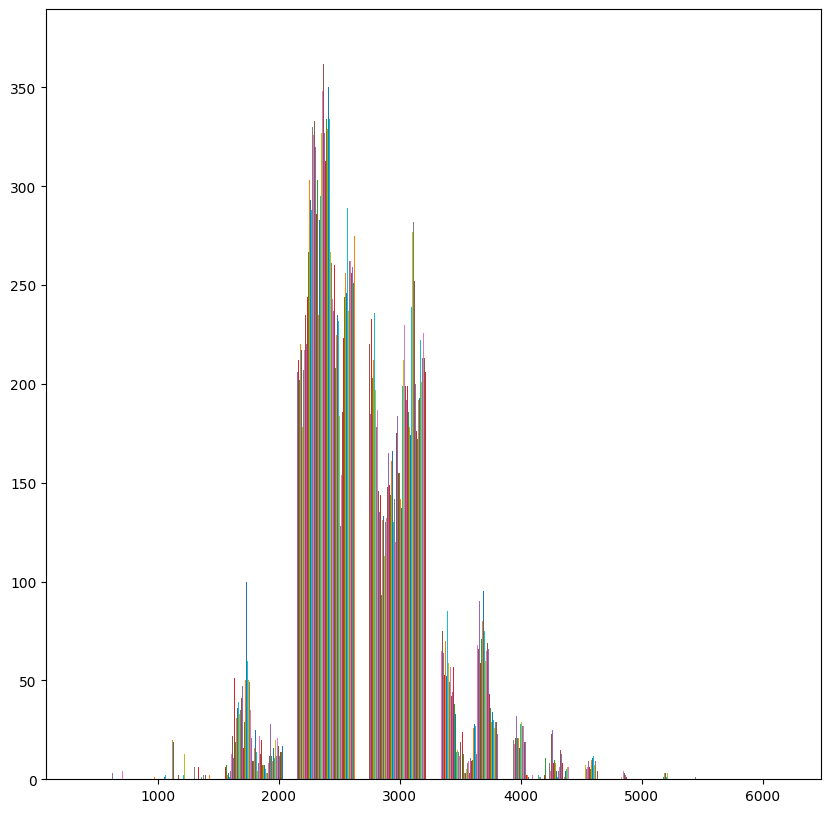

In [ ]:
f = plt.figure(figsize=(10, 10)) 
plt.hist(get_4_band(FILENAME)) 
# plt.imshow(get_image_RGB(FILENAME))
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes(get_4_band(FILENAME))
# plt.colorbar(cax=cax)
plt.show() 


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
class EfficientNetModel:
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            tf.keras.layers.RandomContrast(factor=0.1),
            ],
            name="img_augmentation",
            )
        self.base_model = tf.keras.applications.efficientnet.EfficientNetB2(input_shape=self.input_shape, include_top=False, weights='imagenet')

        self.model = self.build_model()
        
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)
        x = self.data_augmentation(inputs)
        x = self.base_model(x)
        
        for layer in self.base_model.layers[:40]:  #-20
            # if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
                
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        predictions = tf.keras.layers.Dense(self.num_classes, activation='sigmoid')(x)
        model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
        return model
    
    def predict(self, data):
        return self.model.predict(data)
    
    def summary(self):
        return self.model.summary()
    
    def save_model(self, filepath):
        self.model.save(filepath)
        
    def load_model(self, model_path):
        self.model.load_weights(model_path)
        
    def plot_model_architecture(self, file_path):
        tf.keras.utils.plot_model(self, to_file=file_path, show_shapes=True)
        


In [ ]:
# os.environ['TF_KERAS'] = '1'

# load the model
model = EfficientNetModel(input_shape=(64, 64, 3), num_classes=1)
model.load_model('efficientB2_model_3.h5')

# define the input image size
input_size = (64, 64)

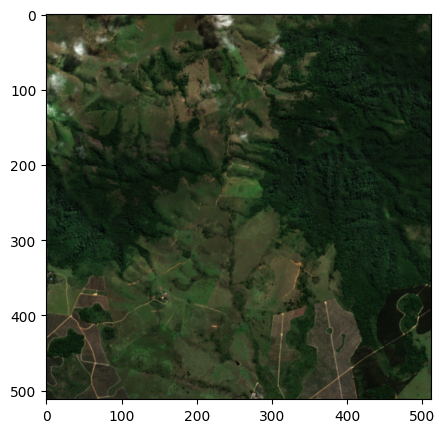

2/2 [==============================] - 3s 211ms/step


0.40625

In [ ]:
def crop_geotiff_to_jpeg(filename, out_dir, block_size):
    # read the input GeoTIFF file
    img = get_image_RGB(filename)
    images = []
    # predictions = []
    

    # set the output directory
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # loop through each block and save as a separate JPEG file
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            # calculate the pixel coordinates of the block
            ulx = i
            uly = j
            lrx = i + block_size
            lry = j + block_size

            # make sure the block is within the image bounds
            if lrx > img.shape[0]:
                lrx = img.shape[0]
                ulx = lrx - block_size
            if lry > img.shape[1]:
                lry = img.shape[1]
                uly = lry - block_size

            # crop the block and save as a JPEG file
            out_file = os.path.join(out_dir, f'{i}_{j}.jpg')
            block = img[ulx:lrx, uly:lry, :]
            cv2.imwrite(out_file, block)

            image = cv2.imread(out_file)
            image = cv2.resize(image, input_size)
            # normalize pixel values to [0, 1]
            image = image.astype('float32') / 255.0 

            image_arr = (image * 255).astype("uint8")
            #show_image(image_arr)

            # prediction = model.predict(np.expand_dims(image, axis = 0))
            # predicted_label = prediction.item()
            # predictions.append(predicted_label)

            images.append(image)
    
    return np.array(images)


def predict(images, t=0.1):
    prediction = model.predict(images)
    apply_threshold = np.vectorize(lambda x, t: 1 if x >= t else 0)
    prediction = apply_threshold(prediction, t)
    return prediction.mean()

images = crop_geotiff_to_jpeg(r"S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_15_08.tif", 'output', 64)
show_image(get_image_RGB(r"S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_15_08.tif"))
predict(images)

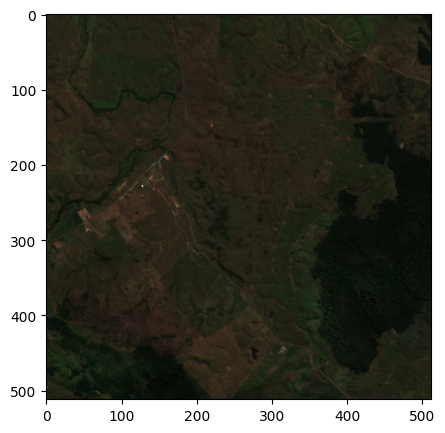

2/2 [==============================] - 0s 211ms/step


0.125

In [ ]:
show_image(get_image_RGB(FILENAME))
images = crop_geotiff_to_jpeg(FILENAME, 'output', 64)
predict(images)

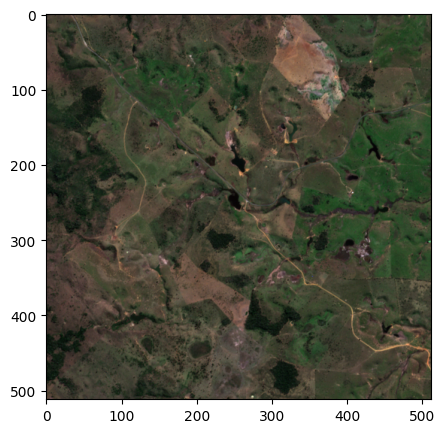

2/2 [==============================] - 1s 252ms/step


0.09375

In [ ]:
show_image(get_image_RGB(r"test.tif"))
images = crop_geotiff_to_jpeg(r"test.tif", 'output', 64)
predict(images)

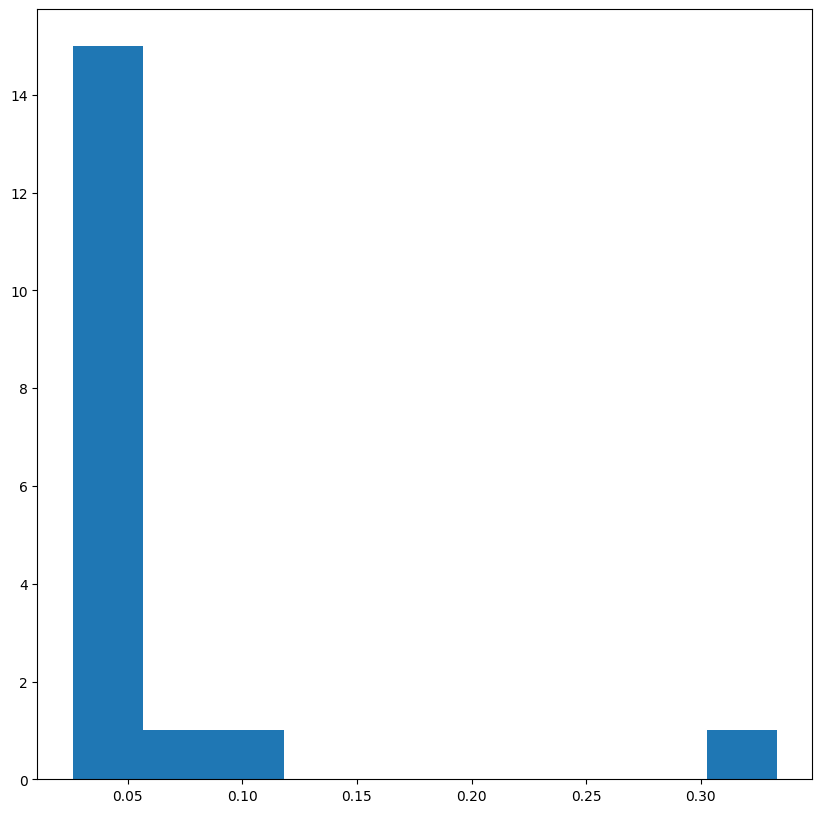

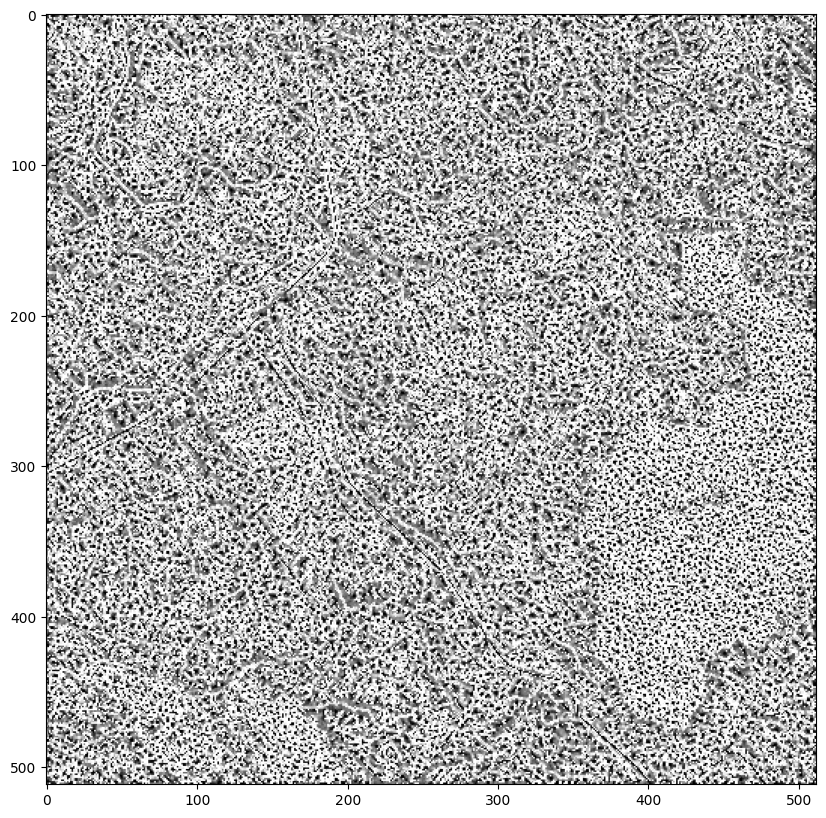

In [ ]:
from skimage import feature
import numpy as np


class LocalBinaryPatterns:
    def __init__(self, image, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.lbp = feature.local_binary_pattern(gray, self.numPoints,
          self.radius, method="uniform")


    def describe(self, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        
        (hist, _) = np.histogram(self.lbp.ravel(),
          bins=np.arange(0, self.numPoints + 3),
          range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist
    
    def show_hist(self):
        f = plt.figure(figsize=(10, 10)) 
        plt.hist(self.describe()) 
        plt.show()
    
    def show_texture_image(self):
        f = plt.figure(figsize=(10, 10)) 
        plt.imshow(self.lbp.astype("uint8"), cmap="gray") 
        plt.show() 



def texture_analysis(r, n_points):
    radius = 2
    n_points = 8 * radius 
    lbp = LocalBinaryPatterns(get_image_RGB(FILENAME), n_points, radius)
    lbp.show_hist()
    lbp.show_texture_image()




radius = 2
n_points = 8 * radius
texture_analysis(radius, n_points)